In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Data Preparation

In [2]:
#Import data
studentInfo = pd.read_csv(r'./OULAD/studentInfo.csv')
assessments = pd.read_csv(r'./OULAD/assessments.csv')
courses = pd.read_csv(r'./OULAD/courses.csv')
studentAssessment = pd.read_csv(r'./OULAD/studentAssessment.csv')
studentRegistration = pd.read_csv(r'./OULAD/studentRegistration.csv')
studentVle = pd.read_csv(r'./OULAD/studentVle.csv')
vle = pd.read_csv(r'./OULAD/vle.csv')

In [3]:
len(studentInfo)

32593

In [4]:
studentInfo.head()

code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability final_result  
0              240          N         Pass  
1               60          N         Pass  
2               60          Y    Withdrawn  
3               60          N         Pass  
4               60          N         Pass

In [5]:
sns.countplot(data=studentInfo, x="final_result")

# Part One: Feature Engineering

#### There are 6 tables aside the studentInformation table. I will extract useful features from these tables and merge them to the student Information table. Before that, I want to calculate the withdrawn and fail rate per module, using the number of withdrawn and fail in each module devided by the total number of record in each module. 

In [13]:
wf_cnt = studentInfo[(studentInfo['final_result'] == 'Withdrawn') | (studentInfo['final_result'] == 'Fail') ].groupby(['code_module']).count()['final_result'].reset_index()
wf_tol = studentInfo.groupby(['code_module']).count()['final_result'].reset_index()
wf_rate = wf_cnt['final_result'] / wf_tol['final_result']
wf_cnt['wf_rate'] = wf_rate
data = pd.merge(studentInfo, wf_cnt[['code_module', 'wf_rate']], how='left', on=['code_module'])

In [8]:
plt.figure(figsize=(15,10))
sns.catplot(
    data=wf_cnt, kind="bar",
    x="code_module", y="wf_rate")

<Figure size 1080x720 with 0 Axes>

In [14]:
f_cnt = studentInfo[(studentInfo['final_result'] == 'Fail')].groupby(['code_module']).count()['final_result'].reset_index()
f_tol = studentInfo.groupby(['code_module']).count()['final_result'].reset_index()
f_rate = f_cnt['final_result'] / f_tol['final_result']
f_cnt['f_rate'] = f_rate
data = pd.merge(data, f_cnt[['code_module', 'f_rate']], how='left', on=['code_module'])

<Figure size 1080x720 with 0 Axes>

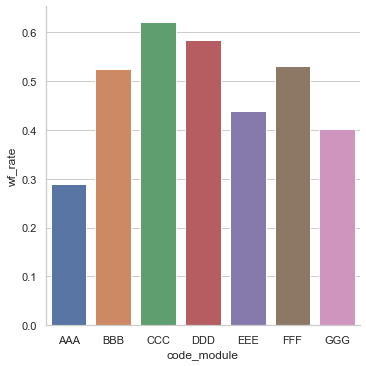

In [10]:
plt.figure(figsize=(15,10))
sns.catplot(
    data=wf_cnt, kind="bar",
    x="code_module", y="wf_rate")

In [11]:
# Over all fail or withdraw rate
len(studentInfo[(studentInfo['final_result'] == 'Withdrawn') | (studentInfo['final_result'] == 'Fail') ]) / len(studentInfo)

0.527966127696131

In [35]:
data.head(10)

code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   
5         AAA             2013J       38053      M                 Wales   
6         AAA             2013J       45462      M              Scotland   
7         AAA             2013J       45642      F  North Western Region   
8         AAA             2013J       52130      F   East Anglian Region   
9         AAA             2013J       53025      M          North Region   

             highest_education imd_band age_band  num_of_prev_attempts  \
0             HE Qualification  90-100%     55<=                     0   
1             HE Qualification   20-30%    35-55                     0   
2        A Level or Equivalent   30-40%    35-55                     0   
3        A Level or Equivalent   50-60%    35-55                     0   
4           Lower Than A Level   50-60%     0-35                     0   
5        A Level or Equivalent   80-90%    35-55                     0   
6             HE Qualification   30-40%     0-35                     0   
7        A Level or Equivalent  90-100%     0-35                     0   
8        A Level or Equivalent   70-80%     0-35                     0   
9  Post Graduate Qualification        ?     55<=                     0   

   studied_credits disability final_result   wf_rate    f_rate  \
0              240          N         Pass  0.290107  0.121658   
1               60          N         Pass  0.290107  0.121658   
2               60          Y    Withdrawn  0.290107  0.121658   
3               60          N         Pass  0.290107  0.121658   
4               60          N         Pass  0.290107  0.121658   
5               60          N         Pass  0.290107  0.121658   
6               60          N         Pass  0.290107  0.121658   
7              120          N         Pass  0.290107  0.121658   
8               90          N         Pass  0.290107  0.121658   
9               60          N         Pass  0.290107  0.121658   

   weighted_score  weighted_day_before_ass  exam_score  
0            82.4                      2.0         NaN  
1            65.4                      0.6         NaN  
2             NaN                      NaN         NaN  
3            76.3                      2.0         NaN  
4            55.0                    -11.4         NaN  
5            66.9                     -2.0         NaN  
6            67.8                     -0.4         NaN  
7            72.5                     -3.9         NaN  
8            71.2                     -1.4         NaN  
9            79.0                      3.9         NaN

## Assessment

#### Table assessment contains information about assessments in module-presentations. Usually, every presentation has a number of assessments followed by the final exam. Table studentAssessment contains the results of students’ assessments. If the student does not submit the assessment, no result is recorded

In [16]:
assessments.head(10)

code_module code_presentation  id_assessment assessment_type date  weight
0         AAA             2013J           1752             TMA   19    10.0
1         AAA             2013J           1753             TMA   54    20.0
2         AAA             2013J           1754             TMA  117    20.0
3         AAA             2013J           1755             TMA  166    20.0
4         AAA             2013J           1756             TMA  215    30.0
5         AAA             2013J           1757            Exam    ?   100.0
6         AAA             2014J           1758             TMA   19    10.0
7         AAA             2014J           1759             TMA   54    20.0
8         AAA             2014J           1760             TMA  117    20.0
9         AAA             2014J           1761             TMA  166    20.0

In [17]:
studentAssessment.head(10)

id_assessment  id_student  date_submitted  is_banked score
0           1752       11391              18          0    78
1           1752       28400              22          0    70
2           1752       31604              17          0    72
3           1752       32885              26          0    69
4           1752       38053              19          0    79
5           1752       45462              20          0    70
6           1752       45642              18          0    72
7           1752       52130              19          0    72
8           1752       53025               9          0    71
9           1752       57506              18          0    68

In [18]:
# Merge table assessment and table studentAssessment on id_assessment
merge_student_ass = pd.merge(assessments, studentAssessment, how='inner', on=['id_assessment'])

In [19]:
merge_student_ass[merge_student_ass['assessment_type'] == 'Exam']

code_module code_presentation  id_assessment assessment_type date  \
52923         CCC             2014B          24290            Exam    ?   
52924         CCC             2014B          24290            Exam    ?   
52925         CCC             2014B          24290            Exam    ?   
52926         CCC             2014B          24290            Exam    ?   
52927         CCC             2014B          24290            Exam    ?   
...           ...               ...            ...             ...  ...   
95980         DDD             2014J          25368            Exam    ?   
95981         DDD             2014J          25368            Exam    ?   
95982         DDD             2014J          25368            Exam    ?   
95983         DDD             2014J          25368            Exam    ?   
95984         DDD             2014J          25368            Exam    ?   

       weight  id_student  date_submitted  is_banked score  
52923   100.0      558914             230          0    32  
52924   100.0      559706             234          0    78  
52925   100.0      559770             230          0    54  
52926   100.0      560114             230          0    64  
52927   100.0      560311             234          0   100  
...       ...         ...             ...        ...   ...  
95980   100.0      652680             243          0    91  
95981   100.0      652732             249          0    47  
95982   100.0      652965             242          0    87  
95983   100.0      653051             242          0    27  
95984   100.0      653319             250          0    64  

[4959 rows x 10 columns]

#### The Exam is a bit different from other assessment types for the following 2 reasons: 1) Its assessment date always missing, since they are scored and used for the final marking immediately at the end of the module. 2)  Exams are treated separately and have the weight equal to 100%; the sum of all other assessments is also 100%. So, we will treat non-Exam assessment and Exam seperately. 

In [20]:
# Filter out non-Exam assessment and Exam
merge_student_ass_not_exam = merge_student_ass[merge_student_ass['assessment_type'] != 'Exam']
merge_student_ass_exam = merge_student_ass[merge_student_ass['assessment_type'] == 'Exam']
merge_student_ass_not_exam.head(10)

code_module code_presentation  id_assessment assessment_type date  weight  \
0         AAA             2013J           1752             TMA   19    10.0   
1         AAA             2013J           1752             TMA   19    10.0   
2         AAA             2013J           1752             TMA   19    10.0   
3         AAA             2013J           1752             TMA   19    10.0   
4         AAA             2013J           1752             TMA   19    10.0   
5         AAA             2013J           1752             TMA   19    10.0   
6         AAA             2013J           1752             TMA   19    10.0   
7         AAA             2013J           1752             TMA   19    10.0   
8         AAA             2013J           1752             TMA   19    10.0   
9         AAA             2013J           1752             TMA   19    10.0   

   id_student  date_submitted  is_banked score  
0       11391              18          0    78  
1       28400              22          0    70  
2       31604              17          0    72  
3       32885              26          0    69  
4       38053              19          0    79  
5       45462              20          0    70  
6       45642              18          0    72  
7       52130              19          0    72  
8       53025               9          0    71  
9       57506              18          0    68

#### We can see students' learning process of each course from the assessment information, so we can find good indicators of students' final result.  I made 2 features using the non-Exam assessment. They are weighted score, and weighted day before assessment. Weighted score means the weighted final score for each class for all the non-Exam assessment. Weighted date before assessment meassures how long  is the submission time ahead of the assessment date.

In [21]:
merge_student_ass_not_exam['date'] = merge_student_ass_not_exam['date'].astype(str).astype(int)
merge_student_ass_not_exam['day_before_ass'] = merge_student_ass_not_exam['date'] - merge_student_ass_not_exam['date_submitted']

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Applications/Utilities/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
merge_student_ass_not_exam.head(10)

code_module code_presentation  id_assessment assessment_type  date  weight  \
0         AAA             2013J           1752             TMA    19    10.0   
1         AAA             2013J           1752             TMA    19    10.0   
2         AAA             2013J           1752             TMA    19    10.0   
3         AAA             2013J           1752             TMA    19    10.0   
4         AAA             2013J           1752             TMA    19    10.0   
5         AAA             2013J           1752             TMA    19    10.0   
6         AAA             2013J           1752             TMA    19    10.0   
7         AAA             2013J           1752             TMA    19    10.0   
8         AAA             2013J           1752             TMA    19    10.0   
9         AAA             2013J           1752             TMA    19    10.0   

   id_student  date_submitted  is_banked score  day_before_ass  
0       11391              18          0    78               1  
1       28400              22          0    70              -3  
2       31604              17          0    72               2  
3       32885              26          0    69              -7  
4       38053              19          0    79               0  
5       45462              20          0    70              -1  
6       45642              18          0    72               1  
7       52130              19          0    72               0  
8       53025               9          0    71              10  
9       57506              18          0    68               1

In [23]:
# I found there are missing values in the score column, I imputed them using the mean value of score which has the 
# same code_module, code_presentation and id_assessment with the missing row. 
df1 = merge_student_ass_not_exam[merge_student_ass_not_exam['score'] != '?']
df1['score'] = df1['score'].astype(int)
for i in range(len(merge_student_ass_not_exam)):
    if merge_student_ass_not_exam.iloc[i]['score'] == '?':
        merge_student_ass_not_exam.iloc[i,9:10] = int(df1[(df1['code_module'] == merge_student_ass_not_exam.iloc[i]['code_module']) & (df1['code_presentation'] == merge_student_ass_not_exam.iloc[i]['code_presentation']) & (df1['id_assessment'] == merge_student_ass_not_exam.iloc[i]['id_assessment'])]['score'].mean())
        

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/Utilities/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
merge_student_ass_not_exam.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                   int64
weight               float64
id_student             int64
date_submitted         int64
is_banked              int64
score                 object
day_before_ass         int64
dtype: object

In [25]:
# To calculate weighted date and weighted day before assessment. I transformed the score and weight column from str to int
merge_student_ass_not_exam['score'] = merge_student_ass_not_exam['score'].astype(str).astype(int)
merge_student_ass_not_exam['weight'] = merge_student_ass_not_exam['weight'].astype(int)
merge_student_ass_not_exam.dtypes

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/Utilities/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


code_module          object
code_presentation    object
id_assessment         int64
assessment_type      object
date                  int64
weight                int64
id_student            int64
date_submitted        int64
is_banked             int64
score                 int64
day_before_ass        int64
dtype: object

In [26]:
# Calculate weighted date and weighted day before assessment.
merge_student_ass_not_exam['weighted_score'] = merge_student_ass_not_exam['score'] * merge_student_ass_not_exam['weight'] * 0.01
merge_student_ass_not_exam['weighted_day_before_ass'] = merge_student_ass_not_exam['day_before_ass'] * merge_student_ass_not_exam['weight'] * 0.01
not_exam_agg = merge_student_ass_not_exam.groupby(['code_module', 'code_presentation', 'id_student']).sum()[['weighted_score', 'weighted_day_before_ass']].reset_index()
not_exam_agg.head(10)


/Applications/Utilities/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/Utilities/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


code_module code_presentation  id_student  weighted_score  \
0         AAA             2013J       11391            82.4   
1         AAA             2013J       28400            65.4   
2         AAA             2013J       31604            76.3   
3         AAA             2013J       32885            55.0   
4         AAA             2013J       38053            66.9   
5         AAA             2013J       45462            67.8   
6         AAA             2013J       45642            72.5   
7         AAA             2013J       52130            71.2   
8         AAA             2013J       53025            79.0   
9         AAA             2013J       57506            74.0   

   weighted_day_before_ass  
0                      2.0  
1                      0.6  
2                      2.0  
3                    -11.4  
4                     -2.0  
5                     -0.4  
6                     -3.9  
7                     -1.4  
8                      3.9  
9                      0.8

In [29]:
len(not_exam_agg)

25839

In [30]:
not_exam_agg[not_exam_agg['code_module'] == 'GGG']

code_module code_presentation  id_student  weighted_score  \
23727         GGG             2013J       24391             0.0   
23728         GGG             2013J       26023             0.0   
23729         GGG             2013J       32239             0.0   
23730         GGG             2013J       35001             0.0   
23731         GGG             2013J       60405             0.0   
...           ...               ...         ...             ...   
25834         GGG             2014J     2620947             0.0   
25835         GGG             2014J     2645731             0.0   
25836         GGG             2014J     2648187             0.0   
25837         GGG             2014J     2679821             0.0   
25838         GGG             2014J     2684003             0.0   

       weighted_day_before_ass  
23727                      0.0  
23728                      0.0  
23729                      0.0  
23730                      0.0  
23731                      0.0  
...                        ...  
25834                      0.0  
25835                      0.0  
25836                      0.0  
25837                      0.0  
25838                      0.0  

[2112 rows x 5 columns]

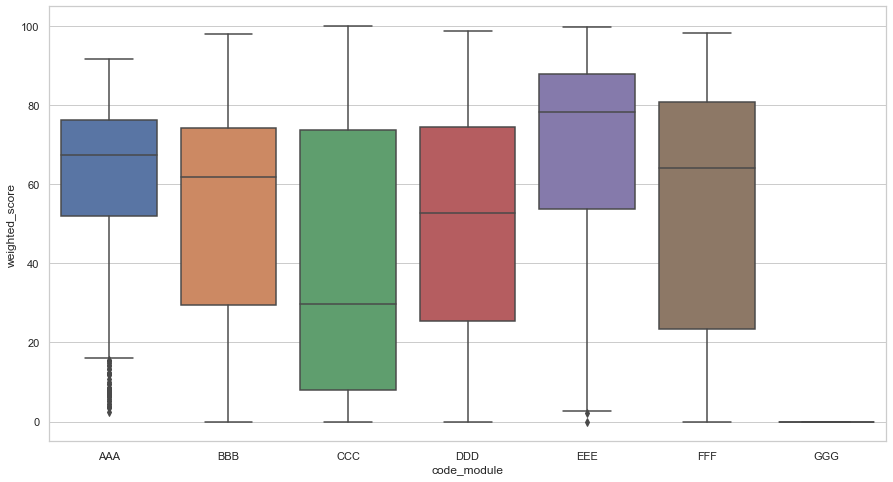

In [31]:
plt.figure(figsize=(15,8))
sns.boxplot(x="code_module", y="weighted_score", data=not_exam_agg)

In [32]:
merge_student_ass_exam.head(10)

code_module code_presentation  id_assessment assessment_type date  \
52923         CCC             2014B          24290            Exam    ?   
52924         CCC             2014B          24290            Exam    ?   
52925         CCC             2014B          24290            Exam    ?   
52926         CCC             2014B          24290            Exam    ?   
52927         CCC             2014B          24290            Exam    ?   
52928         CCC             2014B          24290            Exam    ?   
52929         CCC             2014B          24290            Exam    ?   
52930         CCC             2014B          24290            Exam    ?   
52931         CCC             2014B          24290            Exam    ?   
52932         CCC             2014B          24290            Exam    ?   

       weight  id_student  date_submitted  is_banked score  
52923   100.0      558914             230          0    32  
52924   100.0      559706             234          0    78  
52925   100.0      559770             230          0    54  
52926   100.0      560114             230          0    64  
52927   100.0      560311             234          0   100  
52928   100.0      560494             230          0    92  
52929   100.0      561363             230          0    84  
52930   100.0      561559             230          0    42  
52931   100.0      561774             230          0    62  
52932   100.0      562450             230          0    46

In [33]:
len(merge_student_ass_exam)

4959

In [34]:
# I merged the student information table and their assessment score, submitted day before the assessment due date and 
# exam score. If a student dose not submit the assessment or take the exam, the value in the column would be NaN. 
exam_score = merge_student_ass_exam[['code_module', 'code_presentation', 'id_student', 'score']]
exam_score['score'] = exam_score['score'].astype(str).astype(int)
data = pd.merge(data, not_exam_agg, how='left', on=['code_module', 'code_presentation', 'id_student'])
data = pd.merge(data , exam_score, how='left', on=['code_module', 'code_presentation', 'id_student'])
data.rename(columns = {'score' : 'exam_score'}, inplace = True)

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [36]:
data.head()

code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability final_result   wf_rate    f_rate  \
0              240          N         Pass  0.290107  0.121658   
1               60          N         Pass  0.290107  0.121658   
2               60          Y    Withdrawn  0.290107  0.121658   
3               60          N         Pass  0.290107  0.121658   
4               60          N         Pass  0.290107  0.121658   

   weighted_score  weighted_day_before_ass  exam_score  
0            82.4                      2.0         NaN  
1            65.4                      0.6         NaN  
2             NaN                      NaN         NaN  
3            76.3                      2.0         NaN  
4            55.0                    -11.4         NaN

## Vle(Virtual Learning Environment)

#### The studentVle table contains information about student’s interactions with the VLE. The vle table contains information about the materials available in the VLE. From this 2 dataset, I hope to infer in what degree students refer to the learning material of each course. Let's firstly see how do they look like. 

In [37]:
studentVle.head(10)

code_module code_presentation  id_student  id_site  date  sum_click
0         AAA             2013J       28400   546652   -10          4
1         AAA             2013J       28400   546652   -10          1
2         AAA             2013J       28400   546652   -10          1
3         AAA             2013J       28400   546614   -10         11
4         AAA             2013J       28400   546714   -10          1
5         AAA             2013J       28400   546652   -10          8
6         AAA             2013J       28400   546876   -10          2
7         AAA             2013J       28400   546688   -10         15
8         AAA             2013J       28400   546662   -10         17
9         AAA             2013J       28400   546890   -10          1

In [38]:
studentVle.describe()

id_student       id_site          date     sum_click
count  1.065528e+07  1.065528e+07  1.065528e+07  1.065528e+07
mean   7.333336e+05  7.383234e+05  9.517400e+01  3.716946e+00
std    5.827060e+05  1.312196e+05  7.607130e+01  8.849047e+00
min    6.516000e+03  5.267210e+05 -2.500000e+01  1.000000e+00
25%    5.077430e+05  6.735190e+05  2.500000e+01  1.000000e+00
50%    5.882360e+05  7.300690e+05  8.600000e+01  2.000000e+00
75%    6.464840e+05  8.770300e+05  1.560000e+02  3.000000e+00
max    2.698588e+06  1.049562e+06  2.690000e+02  6.977000e+03

In [39]:
vle.head(10)

id_site code_module code_presentation activity_type week_from week_to
0   546943         AAA             2013J      resource         ?       ?
1   546712         AAA             2013J     oucontent         ?       ?
2   546998         AAA             2013J      resource         ?       ?
3   546888         AAA             2013J           url         ?       ?
4   547035         AAA             2013J      resource         ?       ?
5   546614         AAA             2013J      homepage         ?       ?
6   546897         AAA             2013J           url         ?       ?
7   546678         AAA             2013J     oucontent         ?       ?
8   546933         AAA             2013J      resource         ?       ?
9   546708         AAA             2013J     oucontent         ?       ?

In [40]:
vle.dtypes

id_site               int64
code_module          object
code_presentation    object
activity_type        object
week_from            object
week_to              object
dtype: object

In [41]:
print(len(vle[vle['week_from'] == '?'])/len(vle),
      len(vle[vle['week_to'] == '?'])/len(vle))

0.823852922690132 0.823852922690132


#### 82.39% of the week_from and week_to column is missing. So I decide to simply drop them. 

In [42]:
# Let's see how many vle material in each module.
sns.countplot(data=vle, x="code_module")

In [43]:
vle_cnt = vle.groupby(['code_module']).count()['id_site'].reset_index()
vle_cnt.rename(columns = {'id_site': 'vle_cnt'}, inplace=True)
vle_cnt

code_module  vle_cnt
0         AAA      413
1         BBB     1154
2         CCC      419
3         DDD     1708
4         EEE      336
5         FFF     1967
6         GGG      367

#### The module with code = BBB, DDD, FFF may have heavy workload, because their material is more than other module. 

#### I decide to use how many times they clicked on various materials related to their modules(the sum of clicks per module per students) to measure how they interacted with the Virtual Learning Environment 

In [44]:
sum_clicks_mod_student = studentVle.groupby(['code_module', 'code_presentation', 'id_student']).mean()['sum_click'].reset_index()
sum_clicks_mod_student.head(10)

code_module code_presentation  id_student  sum_click
0         AAA             2013J       11391   4.765306
1         AAA             2013J       28400   3.337209
2         AAA             2013J       30268   3.697368
3         AAA             2013J       31604   3.254902
4         AAA             2013J       32885   2.937500
5         AAA             2013J       38053   3.381743
6         AAA             2013J       45462   4.202817
7         AAA             2013J       45642   2.689266
8         AAA             2013J       52130   3.193929
9         AAA             2013J       53025   3.493363

In [45]:
# Merge the sum_click and vle_cnt to the studentInfo table
data = pd.merge(data, sum_clicks_mod_student, how='left', on=['code_module', 'code_presentation', 'id_student'])
data = pd.merge(data, vle_cnt, how='left', on=['code_module'])
data.head(10)

code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   
5         AAA             2013J       38053      M                 Wales   
6         AAA             2013J       45462      M              Scotland   
7         AAA             2013J       45642      F  North Western Region   
8         AAA             2013J       52130      F   East Anglian Region   
9         AAA             2013J       53025      M          North Region   

             highest_education imd_band age_band  num_of_prev_attempts  \
0             HE Qualification  90-100%     55<=                     0   
1             HE Qualification   20-30%    35-55                     0   
2        A Level or Equivalent   30-40%    35-55                     0   
3        A Level or Equivalent   50-60%    35-55                     0   
4           Lower Than A Level   50-60%     0-35                     0   
5        A Level or Equivalent   80-90%    35-55                     0   
6             HE Qualification   30-40%     0-35                     0   
7        A Level or Equivalent  90-100%     0-35                     0   
8        A Level or Equivalent   70-80%     0-35                     0   
9  Post Graduate Qualification        ?     55<=                     0   

   studied_credits disability final_result   wf_rate    f_rate  \
0              240          N         Pass  0.290107  0.121658   
1               60          N         Pass  0.290107  0.121658   
2               60          Y    Withdrawn  0.290107  0.121658   
3               60          N         Pass  0.290107  0.121658   
4               60          N         Pass  0.290107  0.121658   
5               60          N         Pass  0.290107  0.121658   
6               60          N         Pass  0.290107  0.121658   
7              120          N         Pass  0.290107  0.121658   
8               90          N         Pass  0.290107  0.121658   
9               60          N         Pass  0.290107  0.121658   

   weighted_score  weighted_day_before_ass  exam_score  sum_click  vle_cnt  
0            82.4                      2.0         NaN   4.765306      413  
1            65.4                      0.6         NaN   3.337209      413  
2             NaN                      NaN         NaN   3.697368      413  
3            76.3                      2.0         NaN   3.254902      413  
4            55.0                    -11.4         NaN   2.937500      413  
5            66.9                     -2.0         NaN   3.381743      413  
6            67.8                     -0.4         NaN   4.202817      413  
7            72.5                     -3.9         NaN   2.689266      413  
8            71.2                     -1.4         NaN   3.193929      413  
9            79.0                      3.9         NaN   3.493363      413

## Registration

#### The studentRegistration table contains information about the time when the student registered for the module presentation. For students who unregistered, the date of un-registration is also recorded.

In [46]:
studentRegistration.head(10)

code_module code_presentation  id_student date_registration  \
0         AAA             2013J       11391              -159   
1         AAA             2013J       28400               -53   
2         AAA             2013J       30268               -92   
3         AAA             2013J       31604               -52   
4         AAA             2013J       32885              -176   
5         AAA             2013J       38053              -110   
6         AAA             2013J       45462               -67   
7         AAA             2013J       45642               -29   
8         AAA             2013J       52130               -33   
9         AAA             2013J       53025              -179   

  date_unregistration  
0                   ?  
1                   ?  
2                  12  
3                   ?  
4                   ?  
5                   ?  
6                   ?  
7                   ?  
8                   ?  
9                   ?

In [47]:
studentRegistration.dtypes

code_module            object
code_presentation      object
id_student              int64
date_registration      object
date_unregistration    object
dtype: object

In [48]:
# I want to know how long will a student withdraw a course after the registration. So I made a feature called day_un
# which is the (date_unregistration - data_registration)
sr = studentRegistration[(studentRegistration['date_registration'] != '?') & (studentRegistration['date_unregistration'] != '?')]
sr['date_registration'] = sr['date_registration'].astype(str).astype(int)
sr['date_unregistration'] = sr['date_unregistration'].astype(str).astype(int)
sr['day_un'] = 0
for i in range(len(sr)):
    sr.iloc[i, 5:6] = sr.iloc[i]['date_unregistration'] - sr.iloc[i]['date_registration']
    

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/Utilities/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Applications/Utilities/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [49]:
sr

code_module code_presentation  id_student  date_registration  \
2             AAA             2013J       30268                -92   
15            AAA             2013J       65002               -180   
22            AAA             2013J       94961               -170   
29            AAA             2013J      106247                  5   
41            AAA             2013J      129955               -197   
...           ...               ...         ...                ...   
32576         GGG             2014J     2338614                -23   
32577         GGG             2014J     2342238                -45   
32578         GGG             2014J     2357806               -128   
32586         GGG             2014J     2608143                -45   
32591         GGG             2014J     2679821                -49   

       date_unregistration  day_un  
2                       12     104  
15                      96     276  
22                      72     242  
29                     175     170  
41                     135     332  
...                    ...     ...  
32576                   58      81  
32577                   74     119  
32578                   73     201  
32586                   48      93  
32591                  101     150  

[10033 rows x 6 columns]

In [50]:
sns.catplot(x="code_module", y="day_un", data=sr)

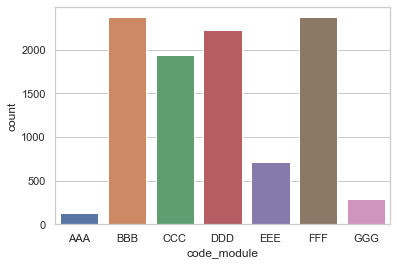

In [51]:
sns.countplot(data=sr, x="code_module")

#### We can see from above that module BBB, CCC, DDD, FFF may be hard, because the withdraw rate is much higher than other modules. Thus, I decided to add a feature called module_w_rate to measure the withdraw rate for each module.

In [52]:
module_w_cnt = sr.groupby(['code_module']).count()['day_un'].reset_index()
module_w_tol = studentRegistration.groupby(['code_module']).count()['date_unregistration'].reset_index()
module_w_rate = module_w_cnt['day_un'] / module_w_tol['date_unregistration']
module_w_cnt['module_w_rate'] = module_w_rate
data = pd.merge(data, module_w_cnt[['code_module', 'module_w_rate']], how='left', on=['code_module'])

<Figure size 1080x720 with 0 Axes>

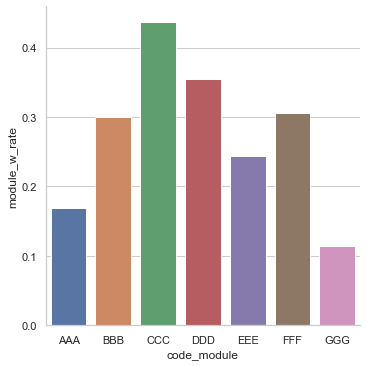

In [53]:
plt.figure(figsize=(15,10))
sns.catplot(
    data=module_w_cnt, kind="bar",
    x="code_module", y="module_w_rate")

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Unregistration Time for module BBB')

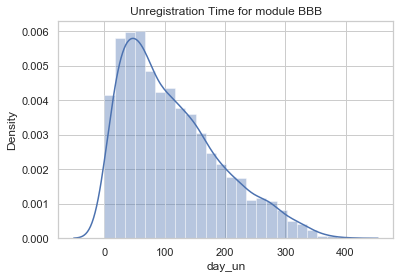

In [54]:
# Let's see the distribution of unregistration day. 
sns.distplot(sr[sr["code_module"] == 'BBB']['day_un']).set_title("Unregistration Time for module BBB")

In [55]:
sns.distplot(sr[sr["code_module"] == 'CCC']['day_un']).set_title("Unregistration Time for module CCC")

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Unregistration Time for module CCC')

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Unregistration Time for module DDD')

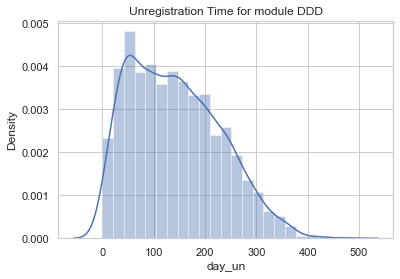

In [56]:
sns.distplot(sr[sr["code_module"] == 'DDD']['day_un']).set_title("Unregistration Time for module DDD")

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Unregistration Time for module FFF')

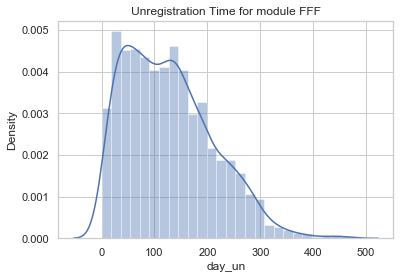

In [57]:
sns.distplot(sr[sr["code_module"] == 'FFF']['day_un']).set_title("Unregistration Time for module FFF")

In [58]:
## Merge the unregistration time with the studentInfo table
data = pd.merge(data, sr[['code_module', 'code_presentation', 'id_student', 'day_un']], how='left', on=['code_module', 'code_presentation', 'id_student'])
data.head(10)

code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   
5         AAA             2013J       38053      M                 Wales   
6         AAA             2013J       45462      M              Scotland   
7         AAA             2013J       45642      F  North Western Region   
8         AAA             2013J       52130      F   East Anglian Region   
9         AAA             2013J       53025      M          North Region   

             highest_education imd_band age_band  num_of_prev_attempts  \
0             HE Qualification  90-100%     55<=                     0   
1             HE Qualification   20-30%    35-55                     0   
2        A Level or Equivalent   30-40%    35-55                     0   
3        A Level or Equivalent   50-60%    35-55                     0   
4           Lower Than A Level   50-60%     0-35                     0   
5        A Level or Equivalent   80-90%    35-55                     0   
6             HE Qualification   30-40%     0-35                     0   
7        A Level or Equivalent  90-100%     0-35                     0   
8        A Level or Equivalent   70-80%     0-35                     0   
9  Post Graduate Qualification        ?     55<=                     0   

   studied_credits  ... final_result   wf_rate    f_rate  weighted_score  \
0              240  ...         Pass  0.290107  0.121658            82.4   
1               60  ...         Pass  0.290107  0.121658            65.4   
2               60  ...    Withdrawn  0.290107  0.121658             NaN   
3               60  ...         Pass  0.290107  0.121658            76.3   
4               60  ...         Pass  0.290107  0.121658            55.0   
5               60  ...         Pass  0.290107  0.121658            66.9   
6               60  ...         Pass  0.290107  0.121658            67.8   
7              120  ...         Pass  0.290107  0.121658            72.5   
8               90  ...         Pass  0.290107  0.121658            71.2   
9               60  ...         Pass  0.290107  0.121658            79.0   

   weighted_day_before_ass  exam_score  sum_click  vle_cnt  module_w_rate  \
0                      2.0         NaN   4.765306      413       0.168449   
1                      0.6         NaN   3.337209      413       0.168449   
2                      NaN         NaN   3.697368      413       0.168449   
3                      2.0         NaN   3.254902      413       0.168449   
4                    -11.4         NaN   2.937500      413       0.168449   
5                     -2.0         NaN   3.381743      413       0.168449   
6                     -0.4         NaN   4.202817      413       0.168449   
7                     -3.9         NaN   2.689266      413       0.168449   
8                     -1.4         NaN   3.193929      413       0.168449   
9                      3.9         NaN   3.493363      413       0.168449   

   day_un  
0     NaN  
1     NaN  
2   104.0  
3     NaN  
4     NaN  
5     NaN  
6     NaN  
7     NaN  
8     NaN  
9     NaN  

[10 rows x 21 columns]

## courses

#### The table contains the list of all available modules and their presentations. 

In [59]:
courses.head(10)

code_module code_presentation  module_presentation_length
0         AAA             2013J                         268
1         AAA             2014J                         269
2         BBB             2013J                         268
3         BBB             2014J                         262
4         BBB             2013B                         240
5         BBB             2014B                         234
6         CCC             2014J                         269
7         CCC             2014B                         241
8         DDD             2013J                         261
9         DDD             2014J                         262

#### There is not a lot to extract from the courses table, the module_presentation_length is evenly distributed across both code_module and code_presentation. Thus, I would not merge it to the StudentInfo table. 

# Data Cleaning

In [60]:
data.head(10)

code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   
5         AAA             2013J       38053      M                 Wales   
6         AAA             2013J       45462      M              Scotland   
7         AAA             2013J       45642      F  North Western Region   
8         AAA             2013J       52130      F   East Anglian Region   
9         AAA             2013J       53025      M          North Region   

             highest_education imd_band age_band  num_of_prev_attempts  \
0             HE Qualification  90-100%     55<=                     0   
1             HE Qualification   20-30%    35-55                     0   
2        A Level or Equivalent   30-40%    35-55                     0   
3        A Level or Equivalent   50-60%    35-55                     0   
4           Lower Than A Level   50-60%     0-35                     0   
5        A Level or Equivalent   80-90%    35-55                     0   
6             HE Qualification   30-40%     0-35                     0   
7        A Level or Equivalent  90-100%     0-35                     0   
8        A Level or Equivalent   70-80%     0-35                     0   
9  Post Graduate Qualification        ?     55<=                     0   

   studied_credits  ... final_result   wf_rate    f_rate  weighted_score  \
0              240  ...         Pass  0.290107  0.121658            82.4   
1               60  ...         Pass  0.290107  0.121658            65.4   
2               60  ...    Withdrawn  0.290107  0.121658             NaN   
3               60  ...         Pass  0.290107  0.121658            76.3   
4               60  ...         Pass  0.290107  0.121658            55.0   
5               60  ...         Pass  0.290107  0.121658            66.9   
6               60  ...         Pass  0.290107  0.121658            67.8   
7              120  ...         Pass  0.290107  0.121658            72.5   
8               90  ...         Pass  0.290107  0.121658            71.2   
9               60  ...         Pass  0.290107  0.121658            79.0   

   weighted_day_before_ass  exam_score  sum_click  vle_cnt  module_w_rate  \
0                      2.0         NaN   4.765306      413       0.168449   
1                      0.6         NaN   3.337209      413       0.168449   
2                      NaN         NaN   3.697368      413       0.168449   
3                      2.0         NaN   3.254902      413       0.168449   
4                    -11.4         NaN   2.937500      413       0.168449   
5                     -2.0         NaN   3.381743      413       0.168449   
6                     -0.4         NaN   4.202817      413       0.168449   
7                     -3.9         NaN   2.689266      413       0.168449   
8                     -1.4         NaN   3.193929      413       0.168449   
9                      3.9         NaN   3.493363      413       0.168449   

   day_un  
0     NaN  
1     NaN  
2   104.0  
3     NaN  
4     NaN  
5     NaN  
6     NaN  
7     NaN  
8     NaN  
9     NaN  

[10 rows x 21 columns]

## Wrong Values

#### From the first 10 lines, we can see the '?' value in the imd_band column should be '>100%'. 

In [61]:
for i in range(len(data)):
    if data.iloc[i]['imd_band'] == '?':
        data.iloc[i, 6:7] = '>100%'

## Label Encoding

In [62]:
data.code_module = pd.Categorical(data.code_module)
data.code_presentation = pd.Categorical(data.code_presentation)
data.gender = pd.Categorical(data.gender)
data.region = pd.Categorical(data.region)
data.highest_education = pd.Categorical(data.highest_education)
data.imd_band = pd.Categorical(data.imd_band)
data.age_band = pd.Categorical(data.age_band)
data.disability = pd.Categorical(data.disability)
data.final_result = pd.Categorical(data.final_result)

In [63]:
data.dtypes

code_module                category
code_presentation          category
id_student                    int64
gender                     category
region                     category
highest_education          category
imd_band                   category
age_band                   category
num_of_prev_attempts          int64
studied_credits               int64
disability                 category
final_result               category
wf_rate                     float64
f_rate                      float64
weighted_score              float64
weighted_day_before_ass     float64
exam_score                  float64
sum_click                   float64
vle_cnt                       int64
module_w_rate               float64
day_un                      float64
dtype: object

In [64]:
# Label encoding
# final_result_cat = {'Distinction' = 0, 'Fail' = 1, 'Pass' = 2, 'Withdrawn' = 3}

obj = ['code_module', 'code_presentation', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 
       'disability', 'final_result']
for i in obj:
    data['{}_cat'.format(i)] = data['{}'.format(i)].cat.codes
data.head(10)

code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   
5         AAA             2013J       38053      M                 Wales   
6         AAA             2013J       45462      M              Scotland   
7         AAA             2013J       45642      F  North Western Region   
8         AAA             2013J       52130      F   East Anglian Region   
9         AAA             2013J       53025      M          North Region   

             highest_education imd_band age_band  num_of_prev_attempts  \
0             HE Qualification  90-100%     55<=                     0   
1             HE Qualification   20-30%    35-55                     0   
2        A Level or Equivalent   30-40%    35-55                     0   
3        A Level or Equivalent   50-60%    35-55                     0   
4           Lower Than A Level   50-60%     0-35                     0   
5        A Level or Equivalent   80-90%    35-55                     0   
6             HE Qualification   30-40%     0-35                     0   
7        A Level or Equivalent  90-100%     0-35                     0   
8        A Level or Equivalent   70-80%     0-35                     0   
9  Post Graduate Qualification    >100%     55<=                     0   

   studied_credits  ... day_un code_module_cat  code_presentation_cat  \
0              240  ...    NaN               0                      1   
1               60  ...    NaN               0                      1   
2               60  ...  104.0               0                      1   
3               60  ...    NaN               0                      1   
4               60  ...    NaN               0                      1   
5               60  ...    NaN               0                      1   
6               60  ...    NaN               0                      1   
7              120  ...    NaN               0                      1   
8               90  ...    NaN               0                      1   
9               60  ...    NaN               0                      1   

   gender_cat  region_cat  highest_education_cat  imd_band_cat  age_band_cat  \
0           1           0                      1             9             2   
1           0           6                      1             2             1   
2           0           5                      0             3             1   
3           0           7                      0             5             1   
4           0          11                      2             5             0   
5           1          10                      0             8             1   
6           1           6                      1             3             0   
7           0           5                      0             9             0   
8           0           0                      0             7             0   
9           1           4                      4            10             2   

   disability_cat  final_result_cat  
0               0                 2  
1               0                 2  
2               1                 3  
3               0                 2  
4               0                 2  
5               0                 2  
6               0                 2  
7               0                 2  
8               0                 2  
9               0                 2  

[10 rows x 30 columns]

In [65]:
data.dtypes

code_module                category
code_presentation          category
id_student                    int64
gender                     category
region                     category
highest_education          category
imd_band                   category
age_band                   category
num_of_prev_attempts          int64
studied_credits               int64
disability                 category
final_result               category
wf_rate                     float64
f_rate                      float64
weighted_score              float64
weighted_day_before_ass     float64
exam_score                  float64
sum_click                   float64
vle_cnt                       int64
module_w_rate               float64
day_un                      float64
code_module_cat                int8
code_presentation_cat          int8
gender_cat                     int8
region_cat                     int8
highest_education_cat          int8
imd_band_cat                   int8
age_band_cat                

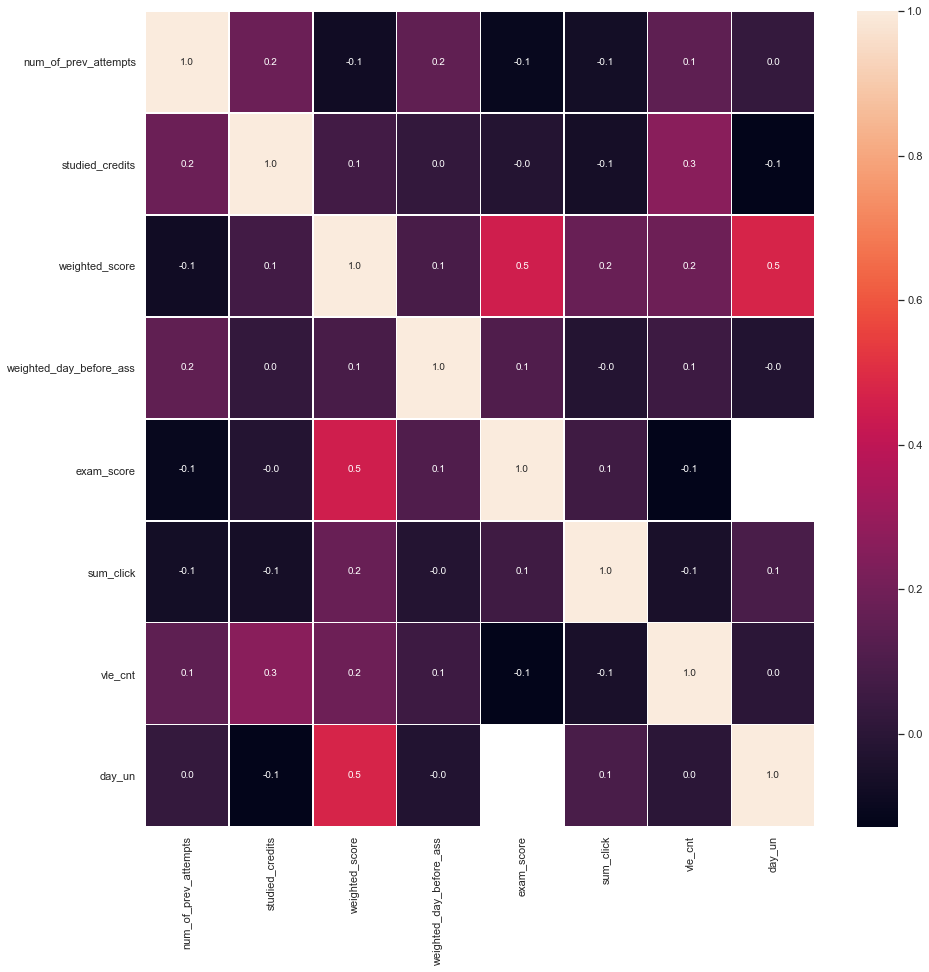

In [66]:
# Draw a corrmap for the numercial features to see their relationship. 
data_num = data[['num_of_prev_attempts', 'studied_credits', 'weighted_score', 'weighted_day_before_ass', 'exam_score', 'sum_click', 'vle_cnt', 'day_un']]
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data_num.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

## Outlier Treatment

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


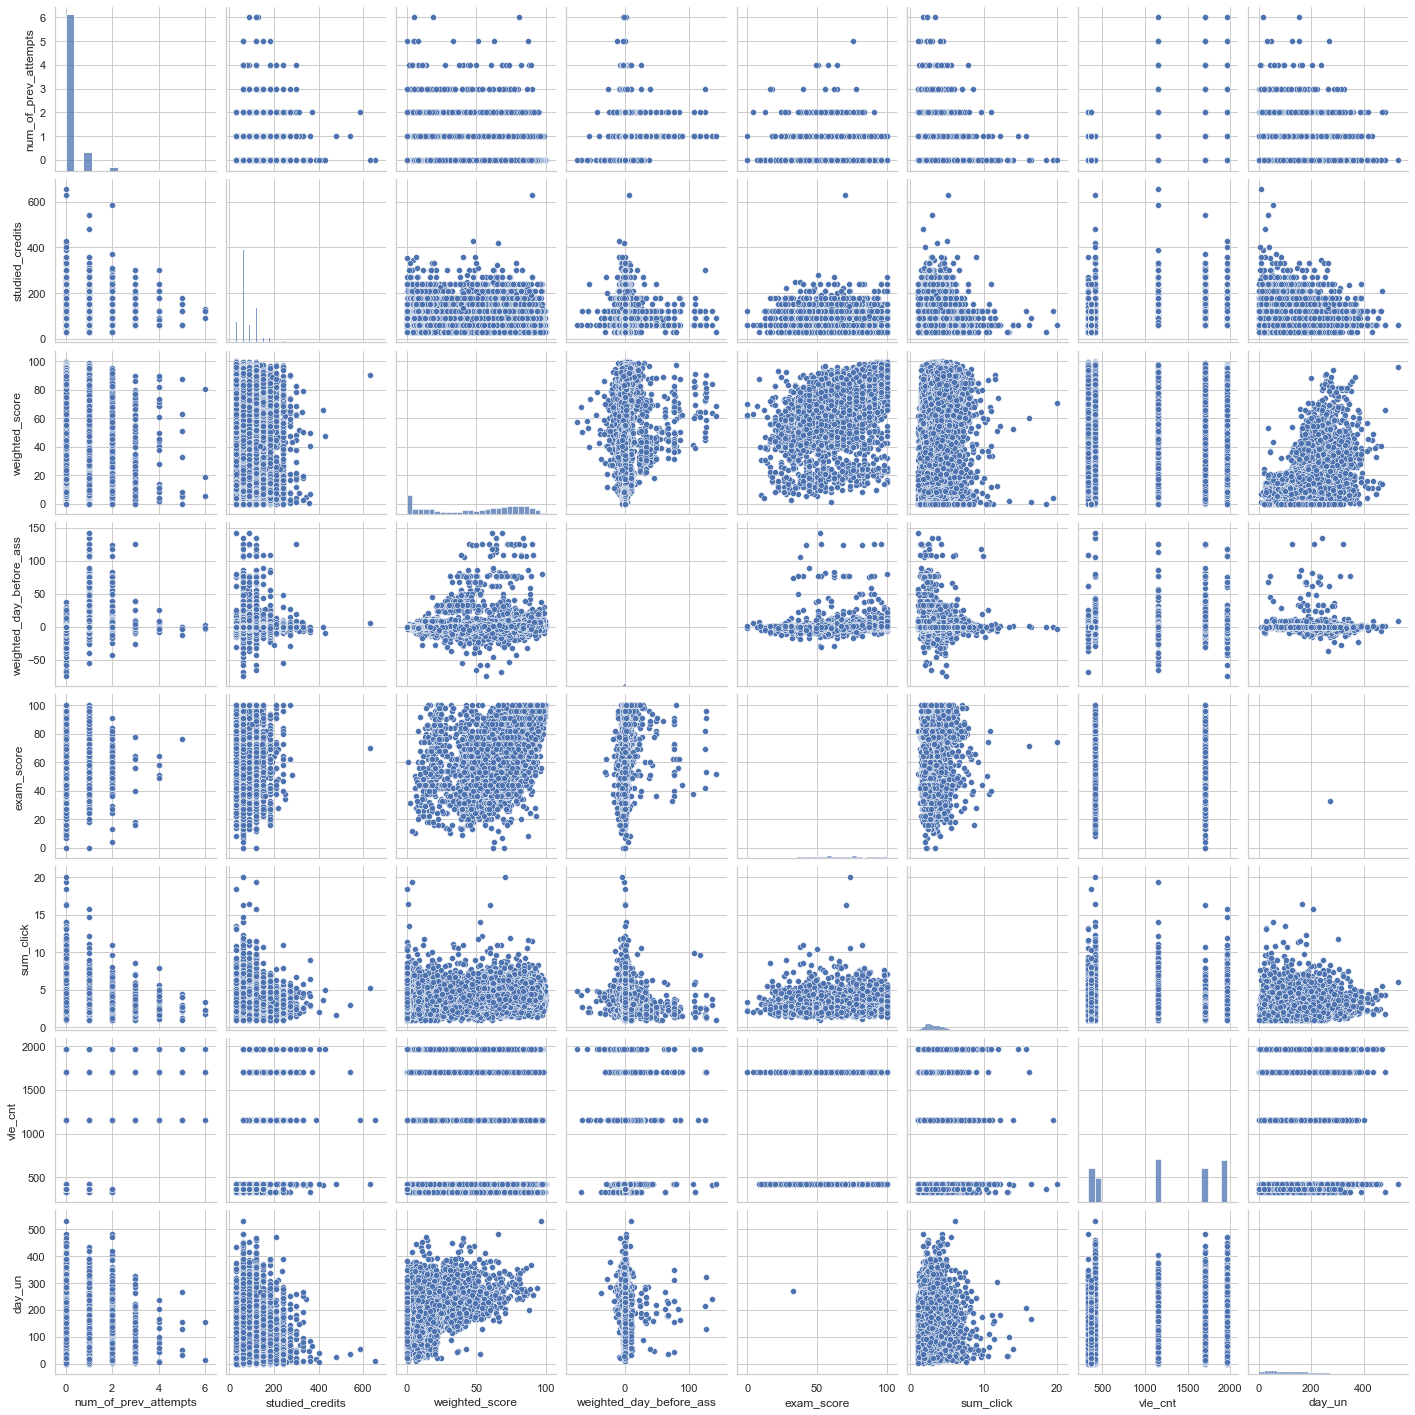

In [67]:

sns.pairplot(data_num, size = 2.5)

In [68]:
data_num.describe()

num_of_prev_attempts  studied_credits  weighted_score  \
count          32593.000000     32593.000000    25839.000000   
mean               0.163225        79.758691       48.405579   
std                0.479758        41.071900       31.848395   
min                0.000000        30.000000        0.000000   
25%                0.000000        60.000000       15.600000   
50%                0.000000        60.000000       55.750000   
75%                0.000000       120.000000       76.960000   
max                6.000000       655.000000      100.000000   

       weighted_day_before_ass   exam_score     sum_click       vle_cnt  \
count             25839.000000  4959.000000  29228.000000  32593.000000   
mean                  0.474487    65.572898      3.268088   1202.405056   
std                   6.941146    20.579186      1.226142    639.235586   
min                 -74.060000     0.000000      1.000000    336.000000   
25%                  -0.750000    51.000000      2.364436    419.000000   
50%                   0.000000    67.000000      3.080000   1154.000000   
75%                   0.880000    82.000000      3.997973   1708.000000   
max                 141.850000   100.000000     20.028933   1967.000000   

             day_un  
count  10033.000000  
mean     128.797568  
std       85.694853  
min        0.000000  
25%       57.000000  
50%      117.000000  
75%      186.000000  
max      531.000000

#### There are outliers in the 'studied_credits', 'sum_click' and 'day_un' features. I decide to drop rows with studied_credits > 250, sum_click > 8,  day_un > 450 , weighted_day_before_ass > 6 or weighted_day_before_ass < -5

In [69]:
data = data[(data['studied_credits'] <= 250)]
data = data[(data['sum_click'] <= 8) | (data['sum_click'].isnull())]
data = data[((data['weighted_day_before_ass'] <= 6) & (data['weighted_day_before_ass'] >= -5)) | (data['weighted_day_before_ass'].isnull())]
data = data[(data['day_un'] <= 450) | (data['day_un'].isnull())]
data

code_module code_presentation  id_student gender                region  \
0             AAA             2013J       11391      M   East Anglian Region   
1             AAA             2013J       28400      F              Scotland   
2             AAA             2013J       30268      F  North Western Region   
3             AAA             2013J       31604      F     South East Region   
5             AAA             2013J       38053      M                 Wales   
...           ...               ...         ...    ...                   ...   
32588         GGG             2014J     2640965      F                 Wales   
32589         GGG             2014J     2645731      F   East Anglian Region   
32590         GGG             2014J     2648187      F          South Region   
32591         GGG             2014J     2679821      F     South East Region   
32592         GGG             2014J     2684003      F      Yorkshire Region   

           highest_education imd_band age_band  num_of_prev_attempts  \
0           HE Qualification  90-100%     55<=                     0   
1           HE Qualification   20-30%    35-55                     0   
2      A Level or Equivalent   30-40%    35-55                     0   
3      A Level or Equivalent   50-60%    35-55                     0   
5      A Level or Equivalent   80-90%    35-55                     0   
...                      ...      ...      ...                   ...   
32588     Lower Than A Level    10-20     0-35                     0   
32589     Lower Than A Level   40-50%    35-55                     0   
32590  A Level or Equivalent   20-30%     0-35                     0   
32591     Lower Than A Level  90-100%    35-55                     0   
32592       HE Qualification   50-60%    35-55                     0   

       studied_credits  ... day_un code_module_cat  code_presentation_cat  \
0                  240  ...    NaN               0                      1   
1                   60  ...    NaN               0                      1   
2                   60  ...  104.0               0                      1   
3                   60  ...    NaN               0                      1   
5                   60  ...    NaN               0                      1   
...                ...  ...    ...             ...                    ...   
32588               30  ...    NaN               6                      3   
32589               30  ...    NaN               6                      3   
32590               30  ...    NaN               6                      3   
32591               30  ...  150.0               6                      3   
32592               30  ...    NaN               6                      3   

       gender_cat  region_cat  highest_education_cat  imd_band_cat  \
0               1           0                      1             9   
1               0           6                      1             2   
2               0           5                      0             3   
3               0           7                      0             5   
5               1          10                      0             8   
...           ...         ...                    ...           ...   
32588           0          10                      2             1   
32589           0           0                      2             4   
32590           0           8                      0             2   
32591           0           7                      2             9   
32592           0          12                      1             5   

       age_band_cat  disability_cat  final_result_cat  
0                 2               0                 2  
1                 1               0                 2  
2                 1               1                 3  
3                 1               0                 2  
5                 1               0                 2  
...             ...             ...               ...  
32588             0   

In [72]:
# Select the cleaned and encoded variables for the machine learning process later.
data_en = data[['code_module_cat', 'code_presentation_cat', 'id_student', 'num_of_prev_attempts', 'studied_credits', 'wf_rate',
                'weighted_score', 'weighted_day_before_ass', 'exam_score', 'sum_click', 'vle_cnt', 'module_w_rate', 'day_un', 
                'final_result_cat', 'gender_cat', 'region_cat', 'highest_education_cat', 'imd_band_cat', 'age_band_cat', 
                'disability_cat']]
data_en

code_module_cat  code_presentation_cat  id_student  \
0                    0                      1       11391   
1                    0                      1       28400   
2                    0                      1       30268   
3                    0                      1       31604   
5                    0                      1       38053   
...                ...                    ...         ...   
32588                6                      3     2640965   
32589                6                      3     2645731   
32590                6                      3     2648187   
32591                6                      3     2679821   
32592                6                      3     2684003   

       num_of_prev_attempts  studied_credits   wf_rate  weighted_score  \
0                         0              240  0.290107            82.4   
1                         0               60  0.290107            65.4   
2                         0               60  0.290107             NaN   
3                         0               60  0.290107            76.3   
5                         0               60  0.290107            66.9   
...                     ...              ...       ...             ...   
32588                     0               30  0.402526             NaN   
32589                     0               30  0.402526             0.0   
32590                     0               30  0.402526             0.0   
32591                     0               30  0.402526             0.0   
32592                     0               30  0.402526             0.0   

       weighted_day_before_ass  exam_score  sum_click  vle_cnt  module_w_rate  \
0                          2.0         NaN   4.765306      413       0.168449   
1                          0.6         NaN   3.337209      413       0.168449   
2                          NaN         NaN   3.697368      413       0.168449   
3                          2.0         NaN   3.254902      413       0.168449   
5                         -2.0         NaN   3.381743      413       0.168449   
...                        ...         ...        ...      ...            ...   
32588                      NaN         NaN   2.157895      367       0.114049   
32589                      0.0         NaN   3.767932      367       0.114049   
32590                      0.0         NaN   2.888889      367       0.114049   
32591                      0.0         NaN   4.508197      367       0.114049   
32592                      0.0         NaN   3.403315      367       0.114049   

       day_un  final_result_cat  gender_cat  region_cat  \
0         NaN                 2           1           0   
1         NaN                 2           0           6   
2       104.0                 3           0           5   
3         NaN                 2           0           7   
5         NaN                 2           1          10   
...       ...               ...         ...         ...   
32588     NaN                 1           0          10   
32589     NaN                 0           0           0   
32590     NaN                 2           0           8   
32591   150.0                 3           0           7   
32592     NaN                 0           0          12   

       highest_education_cat  imd_band_cat  age_band_cat  disability_cat  
0                          1             9             2               0  
1                          1             2             1               0  
2                          0             3             1               1  
3                          0             5             1               0  
5                          0             8             1               0  
...                      ...           ...           ...             ...  
32588                      2             1             0               0  
32589                      2             4             1               0  
32590                      0

In [71]:
data_en.dtypes

code_module_cat               int8
code_presentation_cat         int8
id_student                   int64
num_of_prev_attempts         int64
studied_credits              int64
wf_rate                    float64
weighted_score             float64
weighted_day_before_ass    float64
exam_score                 float64
sum_click                  float64
vle_cnt                      int64
module_w_rate              float64
day_un                     float64
final_result_cat              int8
gender_cat                    int8
region_cat                    int8
highest_education_cat         int8
imd_band_cat                  int8
age_band_cat                  int8
disability_cat                int8
dtype: object

## Missing Values

In [73]:
# To fit the following machine learning model. I need to impute null values in the current table.
data_en.isnull().sum()

code_module_cat                0
code_presentation_cat          0
id_student                     0
num_of_prev_attempts           0
studied_credits                0
wf_rate                        0
weighted_score              6668
weighted_day_before_ass     6668
exam_score                 25711
sum_click                   3302
vle_cnt                        0
module_w_rate                  0
day_un                     20525
final_result_cat               0
gender_cat                     0
region_cat                     0
highest_education_cat          0
imd_band_cat                   0
age_band_cat                   0
disability_cat                 0
dtype: int64

#### Missing values exist in 4 columns, which are 'weighted_score', 'exam_score', 'sum_click' and 'day_un'. Missing values in 'weighted_score' and 'exam_score' means students didn't take the assessment, I will impute them as 0 to distinguish with taking the assessment and getting 0. Missing values in 'sum_click' and 'day_un' means students didn't click the vle material or didn't unregister the courses. I also imput them using -1. 

In [74]:
data_en.fillna(-1, inplace=True)
data_en.isnull().sum()

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


code_module_cat            0
code_presentation_cat      0
id_student                 0
num_of_prev_attempts       0
studied_credits            0
wf_rate                    0
weighted_score             0
weighted_day_before_ass    0
exam_score                 0
sum_click                  0
vle_cnt                    0
module_w_rate              0
day_un                     0
final_result_cat           0
gender_cat                 0
region_cat                 0
highest_education_cat      0
imd_band_cat               0
age_band_cat               0
disability_cat             0
dtype: int64

# Explorative Analysis

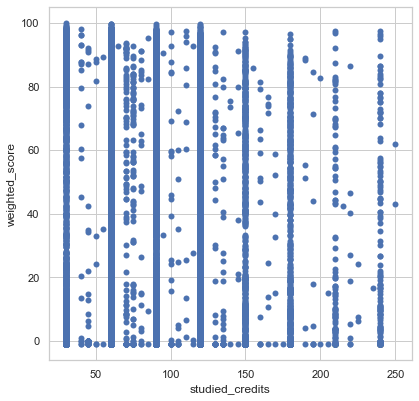

In [75]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x="studied_credits", y="weighted_score", 
                sizes=(1, 8), linewidth=0,
                data=data_en, ax=ax)

#### The student credits has very little impact on the result. 

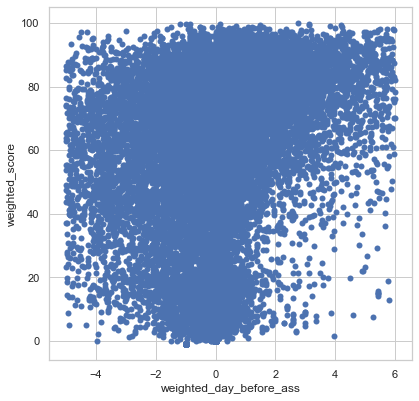

In [76]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x="weighted_day_before_ass", y="weighted_score", 
                sizes=(1, 8), linewidth=0,
                data=data_en, ax=ax)

#### The time of submitting an assessment has very little impact on the result. 

<Figure size 1080x720 with 0 Axes>

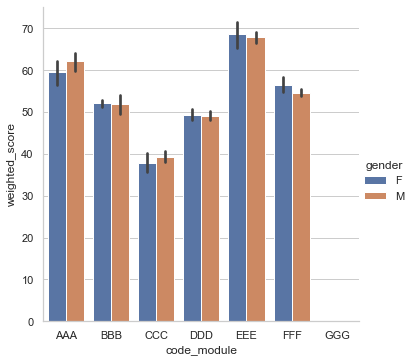

In [77]:
sns.set(style="whitegrid")
plt.figure(figsize=(15,10))
sns.catplot(
    data=data, kind="bar",
    x="code_module", y="weighted_score", hue="gender")

#### There are differences between females and males when learning module AAAA and FFF.  I suggest that males and females form study groups when taking these two modules to help each other learn their own subjects.

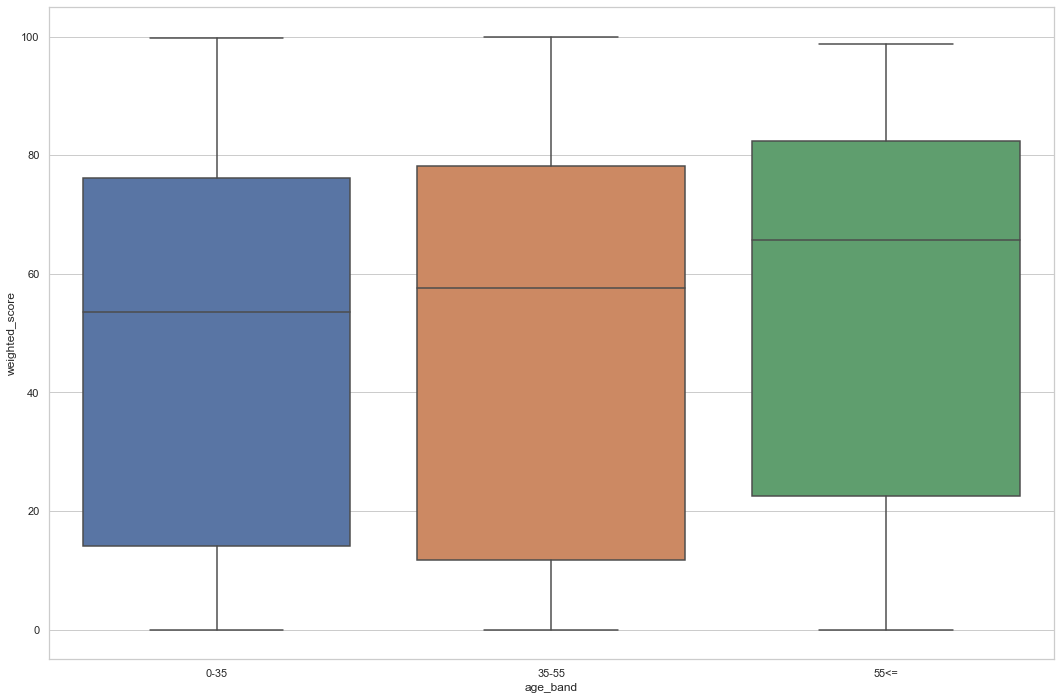

In [78]:
plt.figure(figsize=(18,12))
sns.boxplot(x="age_band", y="weighted_score", data=data)

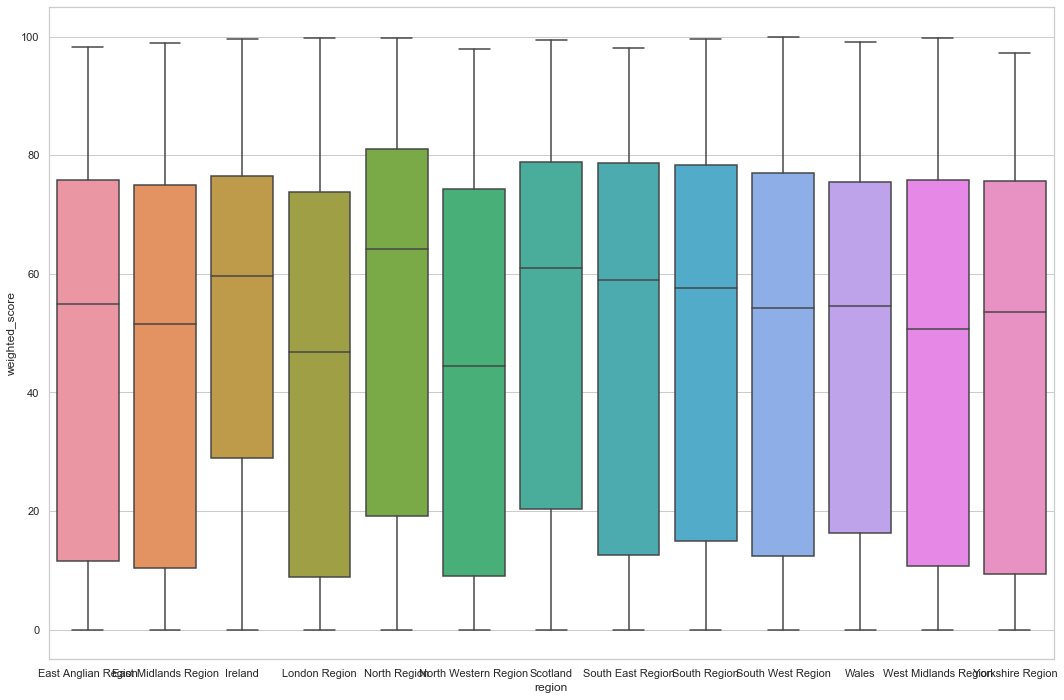

In [79]:
plt.figure(figsize=(18,12))
sns.boxplot(x="region", y="weighted_score", data=data)

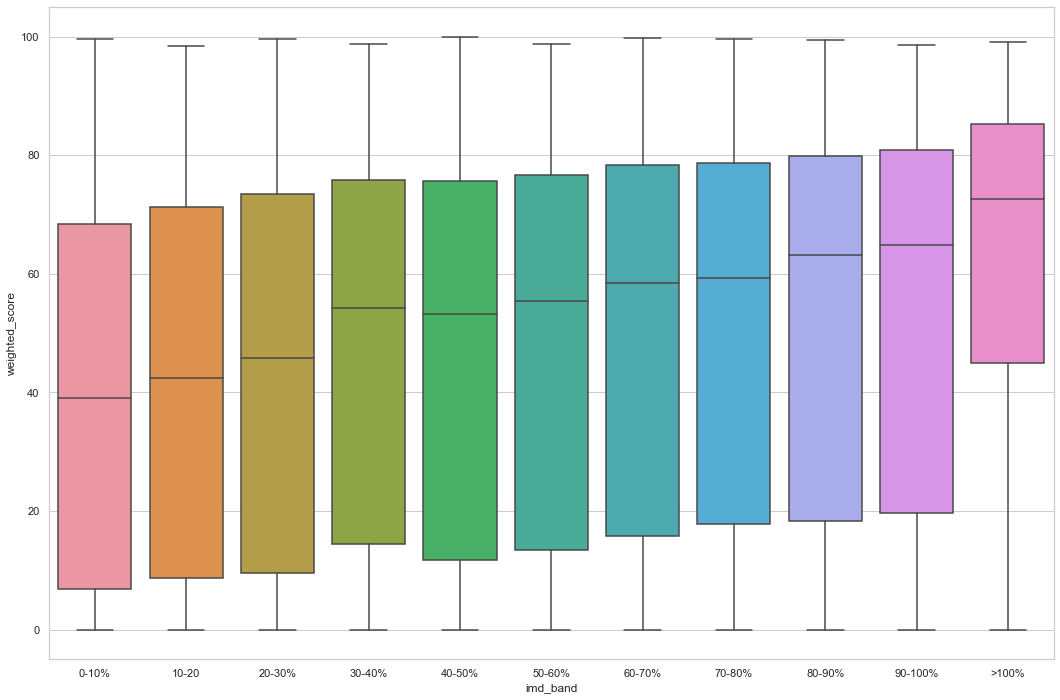

In [80]:
plt.figure(figsize=(18,12))
sns.boxplot(x="imd_band", y="weighted_score", data=data)

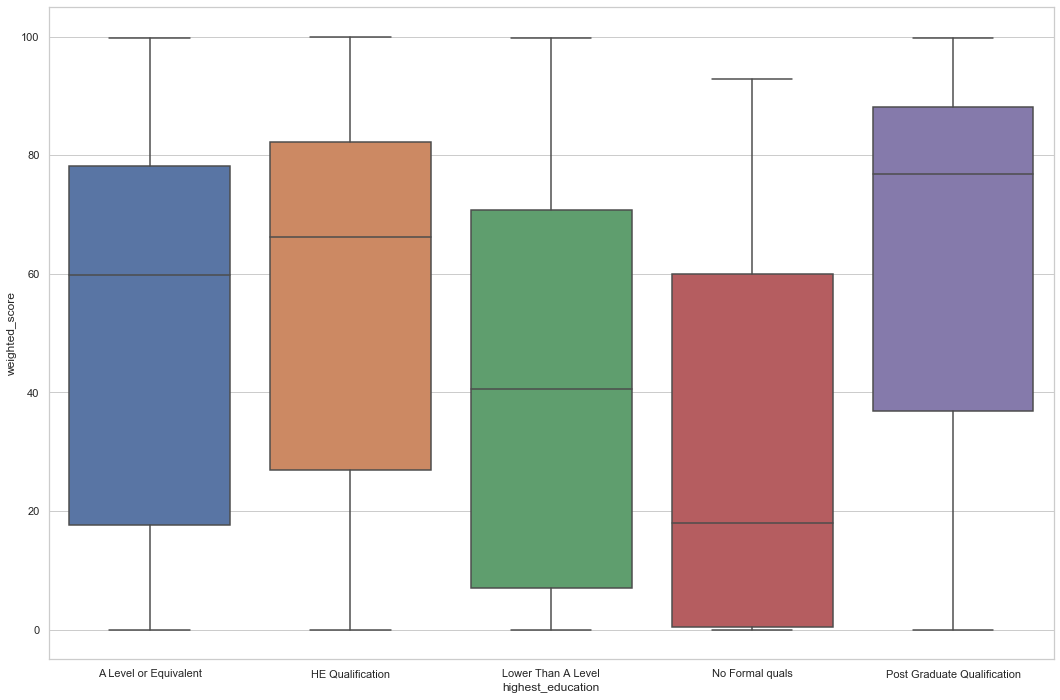

In [81]:
plt.figure(figsize=(18,12))
sns.boxplot(x="highest_education", y="weighted_score", data=data)

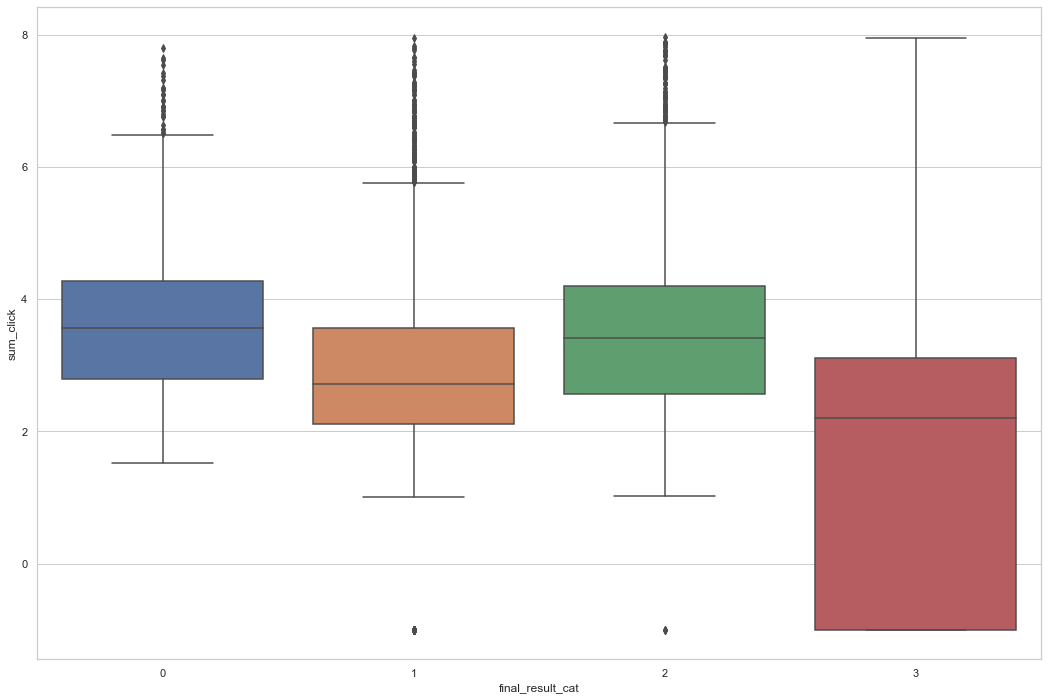

In [82]:
# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
plt.figure(figsize=(18,12))
sns.boxplot(x="final_result_cat", y="sum_click", data=data_en)

#### Students with pass or distinction use the vle more than students who fail or withdraw courses.

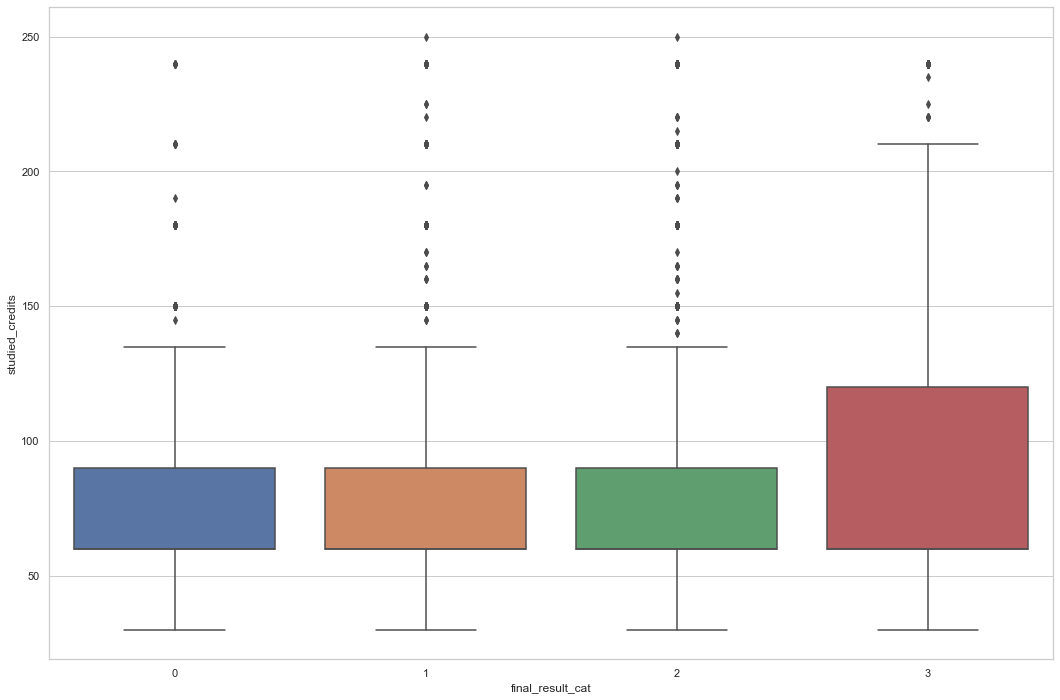

In [83]:
plt.figure(figsize=(18,12))
sns.boxplot(x="final_result_cat", y="studied_credits", data=data_en)

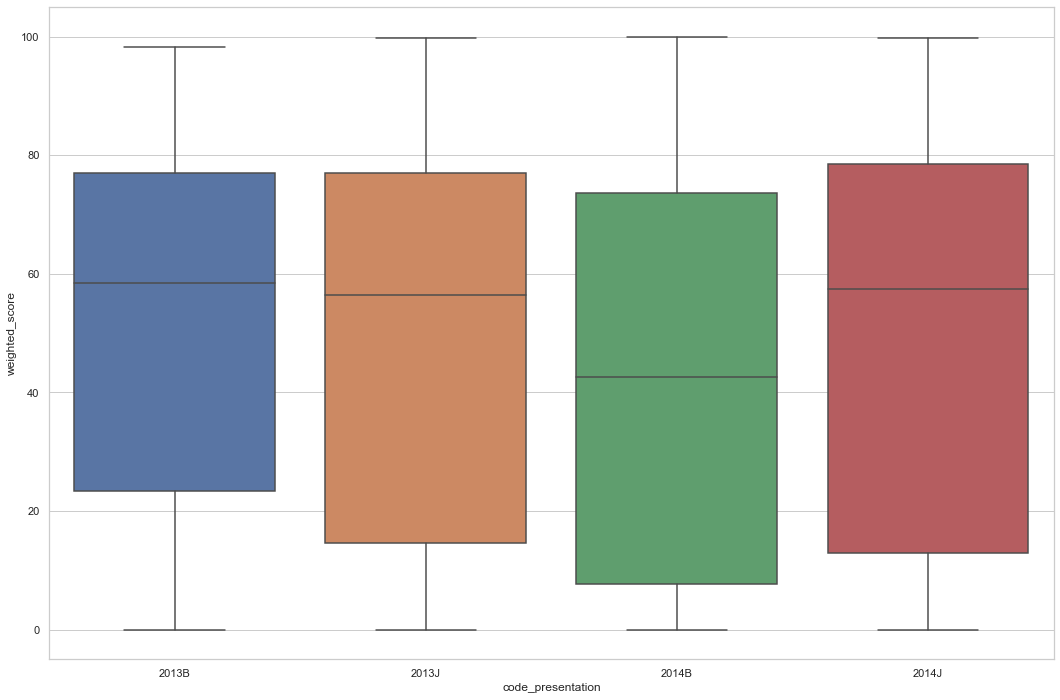

In [84]:
plt.figure(figsize=(18,12))
sns.boxplot(x="code_presentation", y="weighted_score", data=data)

#### The weighted score in 2014B is noticeably lower than other presentations. Let's try to figure out why. 

<Figure size 1800x1440 with 0 Axes>

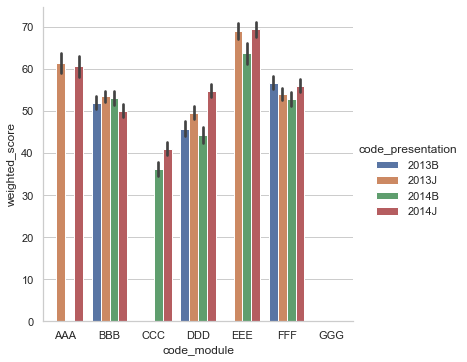

In [85]:
plt.figure(figsize=(25,20))
sns.catplot(
    data=data, kind="bar",
    x="code_module", y="weighted_score", hue="code_presentation")

#### The average weighted score of module 'AAA' is realetively higher than other modules, while it didn't open in the 2014B(it actually only hold on 'J'). At the same time, the average weighted score of module 'CCCC' is lower than other modules, and it hold course from 2014, which lowered the average score of 2014B. It tells us the code_presentation itself doesn't affect students' result, it affects the weighted score simply because of the course schedule. 

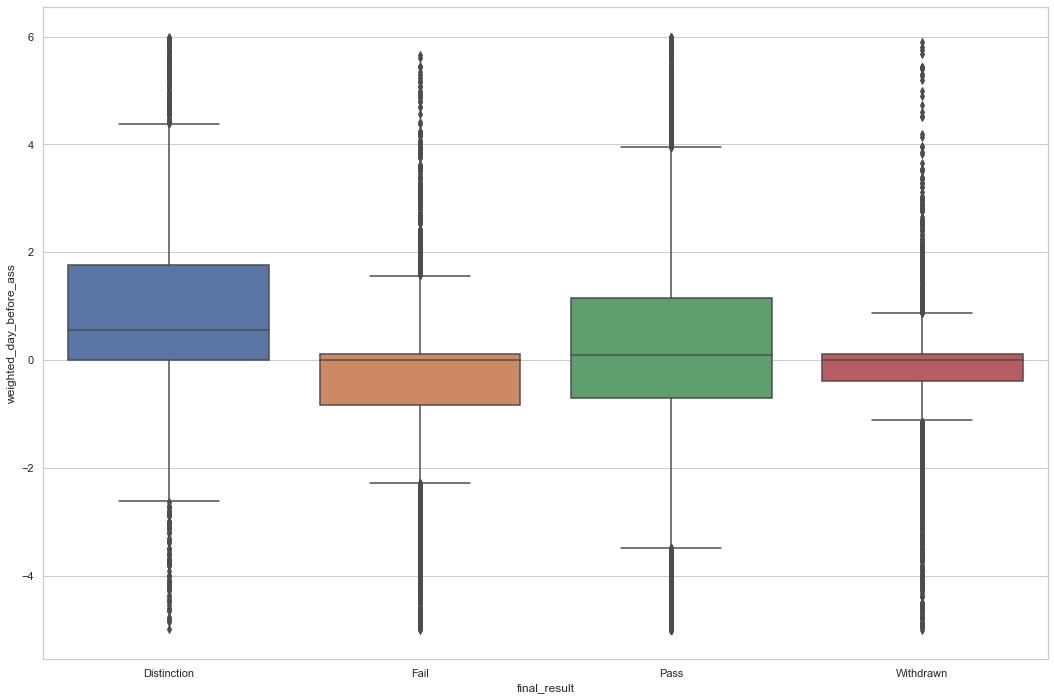

In [86]:
plt.figure(figsize=(18,12))
sns.boxplot(x="final_result", y="weighted_day_before_ass", data=data)

#### Students with pass or distinction submitted the assessment sooner comparing to students who fail or withdraw courses. 

# Machine Learning

In [87]:
# Split the dataset into a train and valid set:
X_train,X_test,Y_train,Y_test=train_test_split(data_en.drop('final_result_cat',axis=1),data_en['final_result_cat'],test_size = 0.2, random_state = 42)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",Y_train.shape)
print("Shape of y_test",Y_test.shape)

Shape of X_train:  (24166, 19)
Shape of X_test:  (6042, 19)
Shape of y_train:  (24166,)
Shape of y_test (6042,)


In [88]:
# Build the rf model
model1=RandomForestClassifier()
model1.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [89]:
#Cross Validation Score
cv_model1 = cross_val_score(estimator = model1, X = X_train, y = Y_train.ravel(), cv = 10)
print("CV: ", cv_model1.mean())
#Training data Score
Y_pred_model1_train = model1.predict(X_train)
accuracy_model1_train = accuracy_score(Y_train, Y_pred_model1_train)
print("Training set: ", accuracy_model1_train)
#Test data Score
Y_pred_model1_test = model1.predict(X_test)
accuracy_model1_test = accuracy_score(Y_test, Y_pred_model1_test)
print("Test set: ", accuracy_model1_test)

CV:  0.8763136975397776
Training set:  0.9999586195481255
Test set:  0.8715657067196293


In [90]:
print(classification_report(Y_test,Y_pred_model1_test))

              precision    recall  f1-score   support

           0       0.69      0.48      0.57       582
           1       0.90      0.80      0.85      1248
           2       0.79      0.91      0.85      2258
           3       1.00      0.99      0.99      1954

    accuracy                           0.87      6042
   macro avg       0.85      0.79      0.81      6042
weighted avg       0.87      0.87      0.87      6042



Text(0.5, 1, 'Confusion matrix of Random Forest, without normalization')

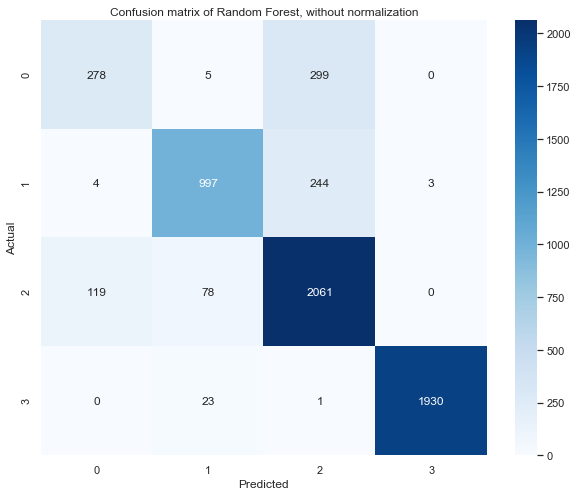

In [91]:
# Plot non-normalized confusion matrix
cm = confusion_matrix(Y_test, Y_pred_model1_test)
df_cm = pd.DataFrame(cm, columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
ax = sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d")
plt.title('Confusion matrix of Random Forest, without normalization')

In [92]:
feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance_normalized': model1.feature_importances_}).sort_values('importance_normalized', ascending = False).reset_index()
feature_importances.head(15)

index                  feature  importance_normalized
0      12                   day_un               0.322073
1       6           weighted_score               0.251312
2       9                sum_click               0.080422
3       8               exam_score               0.069002
4       7  weighted_day_before_ass               0.058313
5       2               id_student               0.046419
6      14               region_cat               0.028037
7      16             imd_band_cat               0.026596
8      11            module_w_rate               0.021183
9       5                  wf_rate               0.016618
10      4          studied_credits               0.015464
11      1    code_presentation_cat               0.014058
12     15    highest_education_cat               0.011506
13      0          code_module_cat               0.009250
14     10                  vle_cnt               0.007671

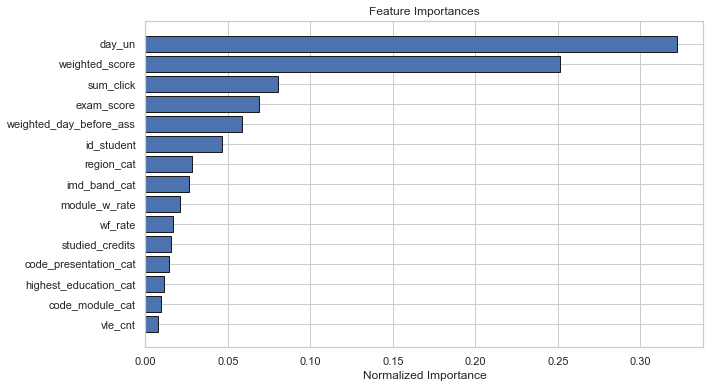

In [93]:
# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()

# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
        feature_importances['importance_normalized'].head(15), 
        align = 'center', edgecolor = 'k')

# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))

# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

#### The result looks pretty good, however, before developing the ml model, we need to remove some variables that directly related to the result. For example, 'weighted_score' and 'exam_score'. We couldn't know them before knowing the result. For the same reason, I also remove the 'day_un' and 'id_student' variable.  

In [94]:
data_ml = data_en.copy()
data_ml = data_ml.drop(['weighted_score', 'exam_score', 'day_un', 'id_student', 'wf_rate', 'module_w_rate', 'sum_click', 'weighted_day_before_ass'], axis = 1)
data_ml.head(10)

code_module_cat  code_presentation_cat  num_of_prev_attempts  \
0                 0                      1                     0   
1                 0                      1                     0   
2                 0                      1                     0   
3                 0                      1                     0   
5                 0                      1                     0   
6                 0                      1                     0   
7                 0                      1                     0   
8                 0                      1                     0   
9                 0                      1                     0   
10                0                      1                     0   

    studied_credits  vle_cnt  final_result_cat  gender_cat  region_cat  \
0               240      413                 2           1           0   
1                60      413                 2           0           6   
2                60      413                 3           0           5   
3                60      413                 2           0           7   
5                60      413                 2           1          10   
6                60      413                 2           1           6   
7               120      413                 2           0           5   
8                90      413                 2           0           0   
9                60      413                 2           1           4   
10               60      413                 2           1           8   

    highest_education_cat  imd_band_cat  age_band_cat  disability_cat  
0                       1             9             2               0  
1                       1             2             1               0  
2                       0             3             1               1  
3                       0             5             1               0  
5                       0             8             1               0  
6                       1             3             0               0  
7                       0             9             0               0  
8                       0             7             0               0  
9                       4            10             2               0  
10                      2             7             1               0

In [95]:
# Split the dataset into a train and valid set:
X_train,X_test,Y_train,Y_test=train_test_split(data_ml.drop('final_result_cat',axis=1),data_ml['final_result_cat'],test_size = 0.2, random_state = 42)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",Y_train.shape)
print("Shape of y_test",Y_test.shape)

Shape of X_train:  (24166, 11)
Shape of X_test:  (6042, 11)
Shape of y_train:  (24166,)
Shape of y_test (6042,)


In [102]:
model2=RandomForestClassifier()
model2.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [103]:
#Cross Validation Score
cv_model2 = cross_val_score(estimator = model2, X = X_train, y = Y_train.ravel(), cv = 10)
print("CV: ", cv_model1.mean())
#Training data Score
Y_pred_model2_train = model2.predict(X_train)
accuracy_model2_train = accuracy_score(Y_train, Y_pred_model2_train)
print("Training set: ", accuracy_model2_train)
#Test data Score
Y_pred_model2_test = model2.predict(X_test)
accuracy_model2_test = accuracy_score(Y_test, Y_pred_model2_test)
print("Test set: ", accuracy_model1_test)

CV:  0.38119672463537796
Training set:  0.8719275014483158
Test set:  0.37619993379675604


In [104]:
print(classification_report(Y_test,Y_pred_model2_test))

              precision    recall  f1-score   support

           0       0.16      0.09      0.12       582
           1       0.27      0.24      0.25      1248
           2       0.43      0.47      0.45      2258
           3       0.41      0.45      0.43      1954

    accuracy                           0.38      6042
   macro avg       0.32      0.31      0.31      6042
weighted avg       0.36      0.38      0.37      6042



Text(0.5, 1, 'Confusion matrix of Random Forest, without normalization')

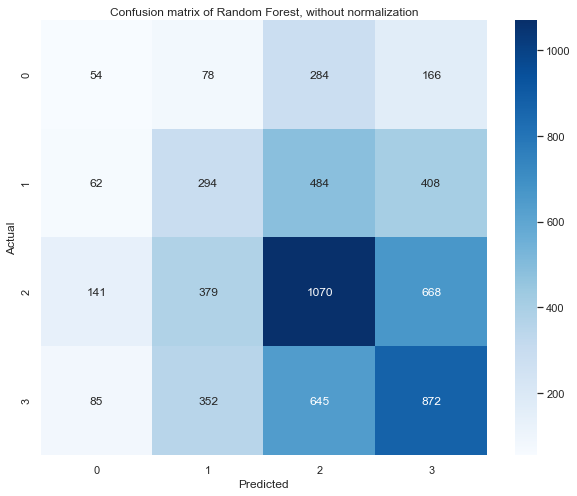

In [105]:
# Plot non-normalized confusion matrix
cm = confusion_matrix(Y_test, Y_pred_model2_test)
df_cm = pd.DataFrame(cm, columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
ax = sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d")
plt.title('Confusion matrix of Random Forest, without normalization')

In [106]:
feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance_normalized': model2.feature_importances_}).sort_values('importance_normalized', ascending = False).reset_index()
feature_importances.head(15)

index                feature  importance_normalized
0       6             region_cat               0.316211
1       8           imd_band_cat               0.236071
2       1  code_presentation_cat               0.090760
3       3        studied_credits               0.080841
4       7  highest_education_cat               0.059263
5       5             gender_cat               0.044837
6       9           age_band_cat               0.044818
7       4                vle_cnt               0.038984
8       0        code_module_cat               0.035984
9       2   num_of_prev_attempts               0.026906
10     10         disability_cat               0.025326

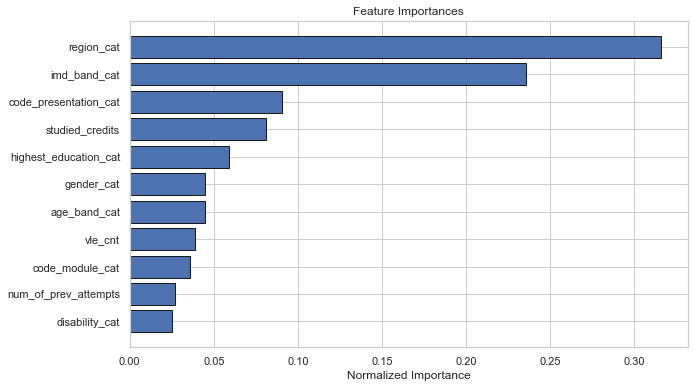

In [107]:
# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()

# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
        feature_importances['importance_normalized'].head(15), 
        align = 'center', edgecolor = 'k')

# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))

# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()